In [24]:
from slfmri import io as slio
from slfmri.lib.stats.ttest import onesample_ttest_perm
from slfmri.lib.stats.corr import r_to_t
from sympy import Symbol, solve
from custom_module import *
import pickle
import re

# prep filepath
code = 'E'
suffix = 'bp001010'

fname_ptrn = fr'Rat_CAMRI_400um_ATLAS-(\d+)_{code}.nii.gz'
mask_path = '../Template/Rat_CAMRI_400um_MASK_v2-1.nii.gz'

refe_pm = slio.PathMan('../Results/UNCCH_CAMRI/140_Pacellation/')
oput_pm = slio.PathMan('../Results/UNCCH_CAMRI/150_CommunityDetection/')

parcels_path = refe_pm(f'./Rat_CAMRI_400um_ATLAS-filtered_E.nii.gz')

# load data\
mask_nii = nib.load(mask_path)
mask_idx = np.nonzero(mask_nii.dataobj)
parcels_nii = nib.load(parcels_path)

# Load temporal profiles from above data and generate numpy array for statistics
connmat_path = oput_pm(f'connmat_E.pkl')
with open(connmat_path, 'rb') as f:
    values = pickle.load(f)

# Load significnat matrix
perm_path = oput_pm(f'connmat_sig_E.npy')

# Treshold
sig_b = np.load(perm_path)
sig_b = np.tanh(sig_b)
t, p = r_to_t(sig_b, 450)
sig_b[p >= 0.05] = 0

# Load dataset structure
pipe = pn.load('..', verbose=False)
pipe.set_package(0)

In [15]:
def convert_to_matrix(data, num_col, fisher=False):
    # Check positive connectivity matrix
    matrix_mask = np.tril(np.ones([num_col] * 2), k=-1)
    output_matrix = matrix_mask * 0
    if fisher:
        mat = np.tanh(data[..., 0])
    else:
        mat = data[..., 0]
    output_matrix[np.nonzero(matrix_mask)] = mat
    output_matrix = fill_upperhalf(output_matrix)
    
    # remove zero values for plotting
    thr_matrix = output_matrix.copy()
    thr_matrix[thr_matrix == 0] = np.nan
    thr_matrix.columns += 1
    thr_matrix.index += 1
    return thr_matrix

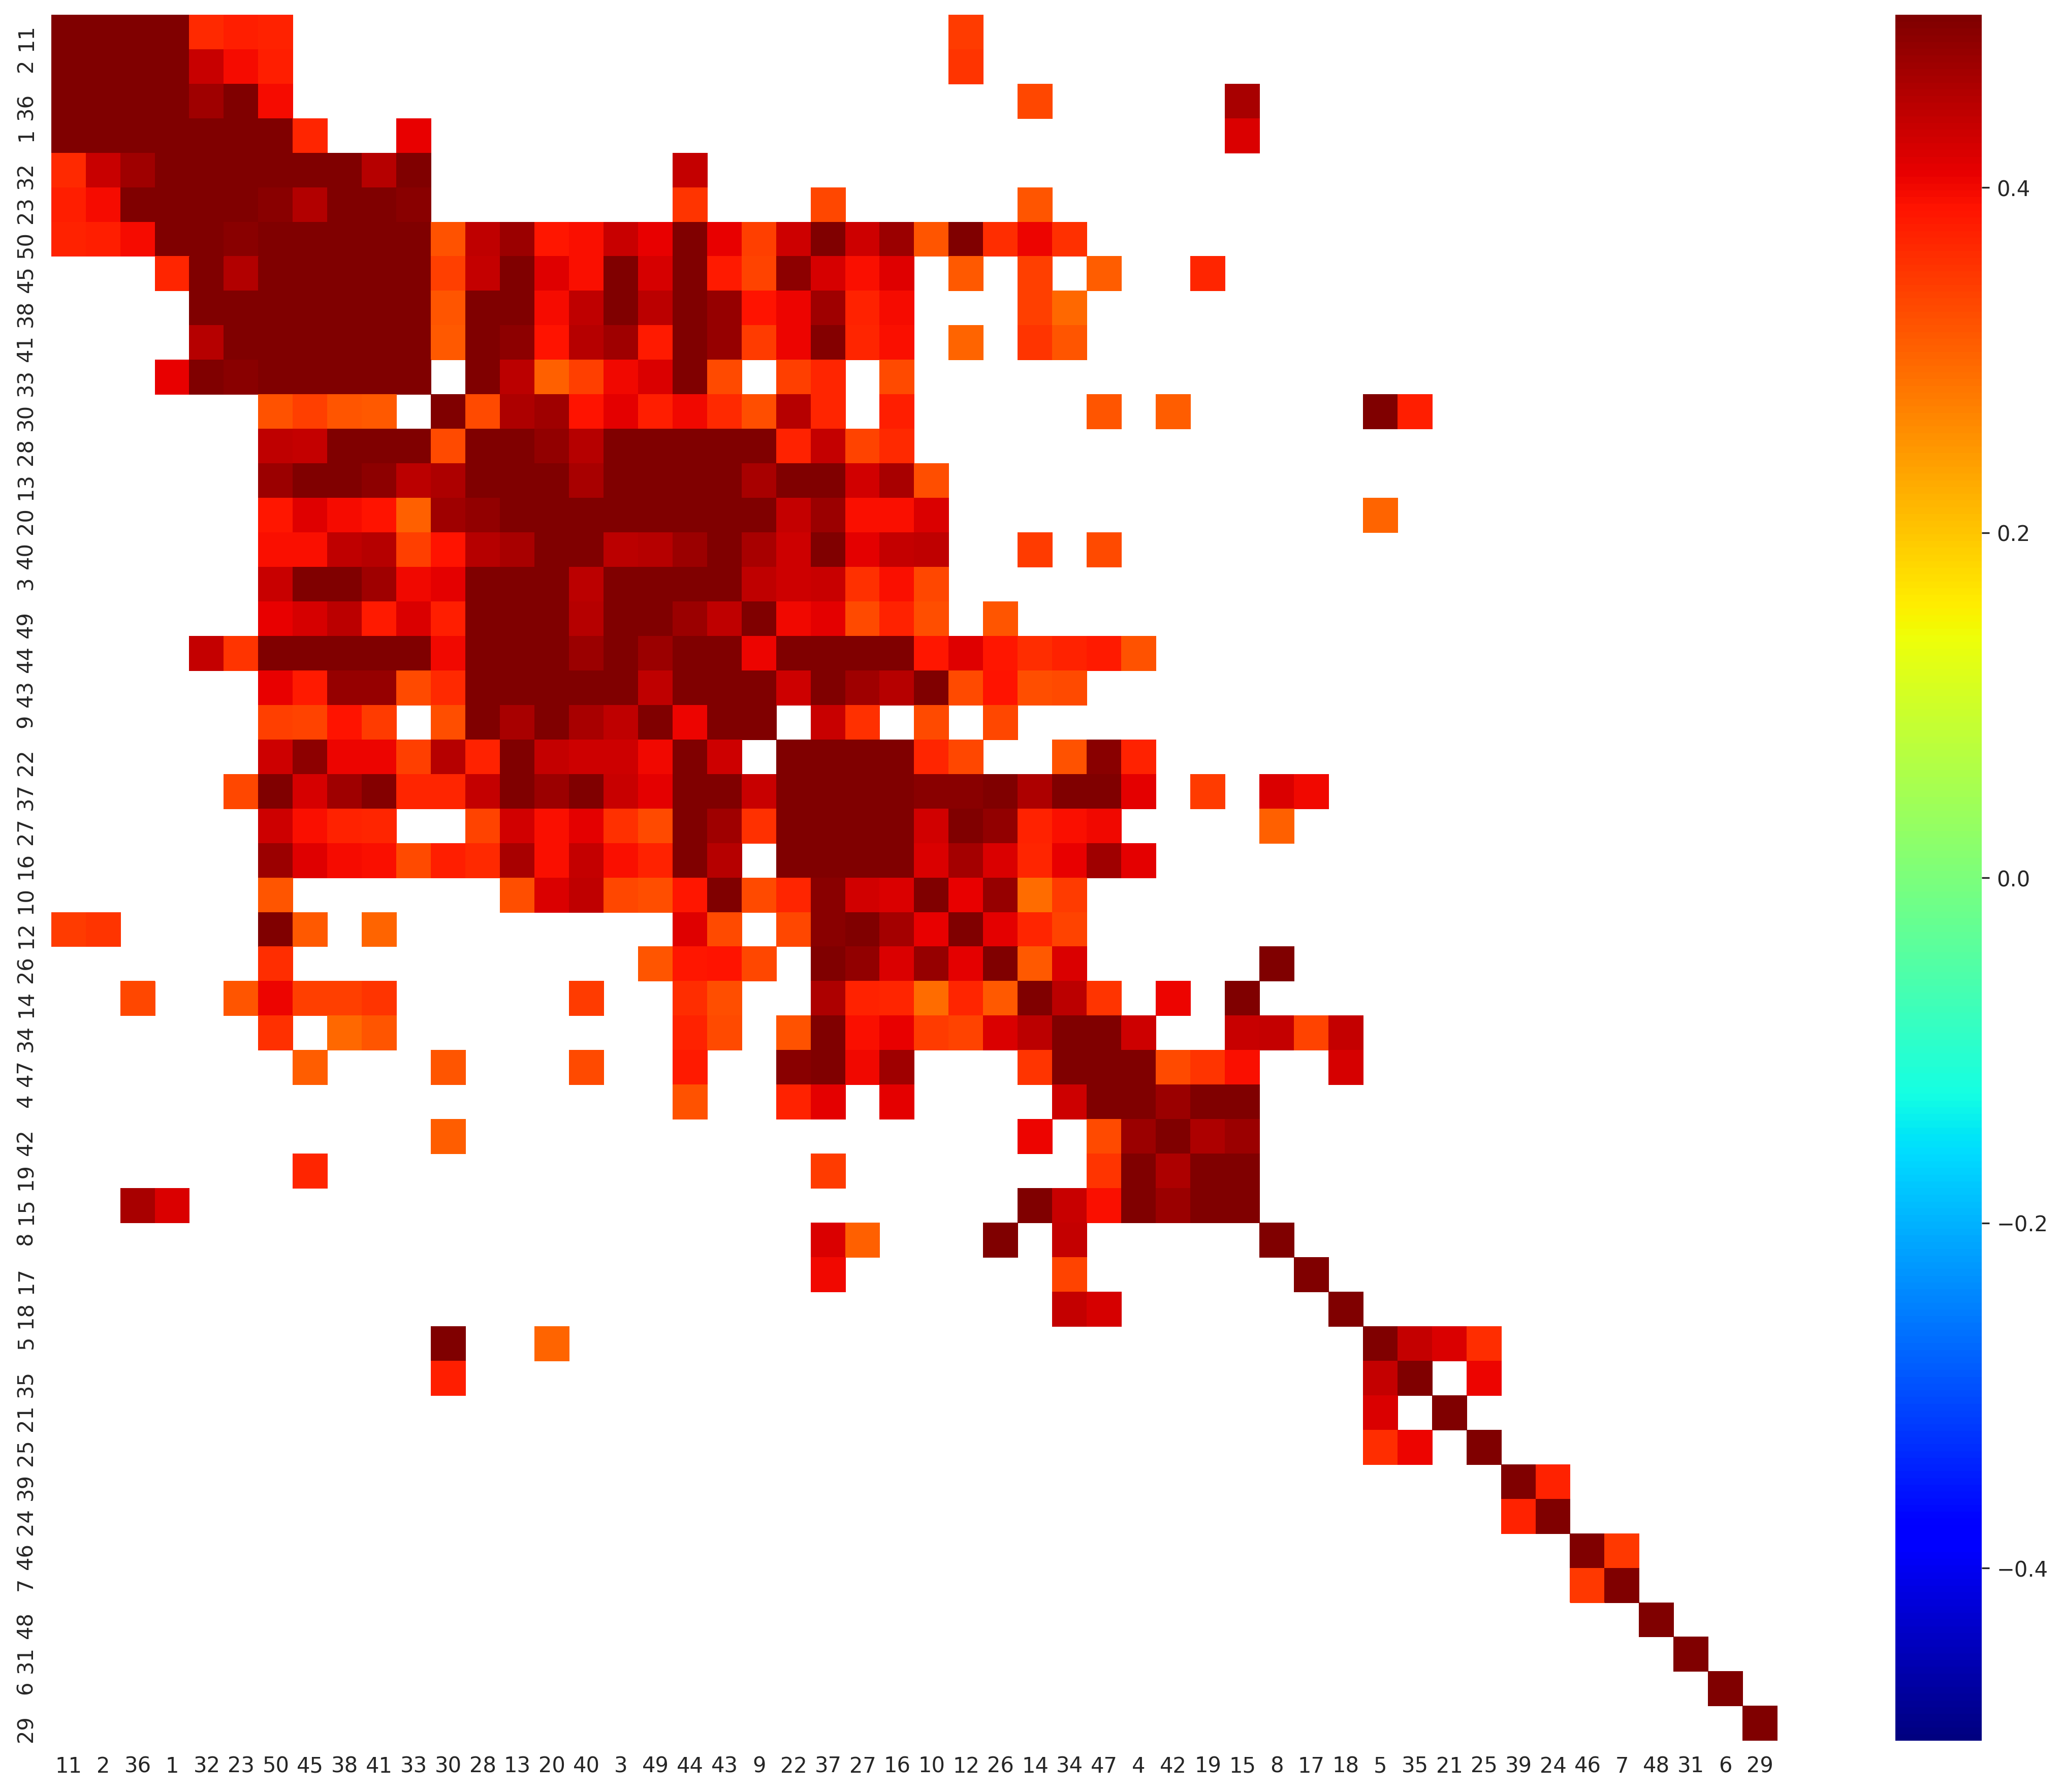

In [25]:
# get number of column of dataset
n = Symbol('n')
eq = n*(n-1) - values.mean(-1).shape[0]*2
num_col = [s for s in solve(eq) if s > 0][0]

# Modular structure
module_dict = dict(M1=[11, 2, 36, 1, 32, 23, 50],
                   M2=[45, 38, 41, 33, 30, 28, 13, 20, 40, 3, 49, 44, 43, 9, 22],
                   M3=[37, 27, 16, 10, 12, 26, 14, 34, 47, 4, 42,19, 15, 8, 17, 18],
                   M4=[5, 35, 21, 25],
                   M5=[39, 24, 46, 7, 48, 31, 6, 29])

indice = np.concatenate([v for v in module_dict.values()])
cord = np.concatenate(list(module_dict.values())).tolist()
# plot group matrix
mat = convert_to_matrix(sig_b, num_col)

fig, ax = plt.subplots(1, 1, figsize=[20, 15], dpi=300)
sns.heatmap(mat.loc[indice, indice], vmin=-0.5, vmax=0.5, cmap='jet', ax=ax)
ax.set_aspect(1)

In [34]:
thr_matrix = mat

In [4]:
def data_randseg(dset, step_code, output_path, mask, n_sample=3, pval=None,
                 size_sample=100, stdout=None, stderr=None):
    """ 
    This item need to be redesigned for interface
    This code takes the mean value of data into account as a regressor to handle the baseline
    """
    from tqdm.notebook import tqdm
    
    if stdout is None:
        stdout = sys.stdout
    if stderr is None:
        stderr = sys.stderr

    class_id = 1
    stdout.write('[UNCCH_CAMRI] Simple random segment:\n')
    try:
        if not os.path.exists(output_path):
            os.mkdir(output_path)
        stdout.write(f'Mask: {mask}\n')
        mask_nii = nib.load(mask)
        mask_idx = np.nonzero(mask_nii.dataobj)

        for subj in tqdm(dset.params[class_id].subjects):
            subj_path = os.path.join(output_path, subj)
            if not os.path.exists(subj_path):
                os.mkdir(subj_path)
            stdout.write(f'  Load {subj}...\n')
            list_of_files = dset(class_id, steps=[step_code], subjects=subj).df.Abspath

            stdout.write(f'    Total number of files: {len(list_of_files)}...\n')
            if len(list_of_files) > 1:
                # concat files
                input_data = []
                onsets = []
                for oid, f in enumerate(list_of_files):
                    loaded_data = np.asarray(nib.load(f).dataobj)[mask_idx]
                    input_data.append(loaded_data)
                    if oid == 0:
                        onsets.append(0)
                    else:
                        onsets.append(input_data[oid-1].shape[-1] + onsets[-1])
                input_data = np.concatenate(input_data, -1)
                max_size = input_data.shape[1] - size_sample
                onsets = [o for o in onsets if o <= max_size]
            else:
                input_nii = nib.load(list_of_files[0])
                input_data = np.asarray(input_nii.dataobj)[mask_idx]
                onsets = None
            n_frame = input_data.shape[-1]
            stdout.write(f'    Total number of frames: {n_frame}\n')

            # random sampling
            if len(list_of_files) > 1:
                sampled_onsets = np.random.choice(onsets, n_sample, replace=False)
            else:
                sampled_onsets = np.random.choice(n_frame - size_sample - 1, n_sample, replace=False)
            for time, onset in enumerate(sampled_onsets):
                fname = os.path.join(subj_path, f'{subj}_run-{time + 1}_cap')
                if not os.path.exists(f'{fname}.nii.gz'):
                    trial_data = input_data[..., onset:onset+size_sample]
                    output_data = np.zeros(list(mask_nii.shape) + [trial_data.shape[-1]])
                    output_data[mask_idx] = trial_data
                    output_nii = nib.Nifti1Image(output_data, affine=input_nii.affine)
                    output_nii.header['qform_code'] = 1
                    output_nii.header['sform_code'] = 0
                    output_nii.to_filename(f'{fname}.nii.gz')
                    stdout.write(f'{time+1}..')
                else:
                    pass
            stdout.write('\n')
        stdout.write('Done..\n')
    except:
        import traceback
        stderr.write('[ERROR] Failed.\n')
        traceback.print_exception(*sys.exc_info(), file=stderr)
        return 1
    return 0

In [8]:
dcode_rsfmri = f'05A'
output_dr = f'../Processing/UNCCH_CAMRI/07F_ReDataRandSeg-bp001010'
dset_rsfmri = pipe.get_dset(dcode_rsfmri)
data_randseg(dset_rsfmri, dcode_rsfmri, output_dr, 
             mask_path, size_sample=150, pval=0.05)

[UNCCH_CAMRI] Simple random segment:
Mask: ../Template/Rat_CAMRI_400um_MASK_v2-1.nii.gz


  Load sub-DRRA01F...
    Total number of files: 1...
    Total number of frames: 900

  Load sub-DRRA01M...
    Total number of files: 1...
    Total number of frames: 401

  Load sub-DRRA02F...
    Total number of files: 1...
    Total number of frames: 900

  Load sub-DRRA02M...
    Total number of files: 1...
    Total number of frames: 900

  Load sub-DRRA03M...
    Total number of files: 1...
    Total number of frames: 900

  Load sub-DRRA04F...
    Total number of files: 1...
    Total number of frames: 900

  Load sub-DRRA04M...
    Total number of files: 1...
    Total number of frames: 900

  Load sub-DRRA05F...
    Total number of files: 1...
    Total number of frames: 900

  Load sub-DRRA05M...
    Total number of files: 1...
    Total number of frames: 900

  Load sub-DRRA06F...
    Total number of files: 1...
    Total number of frames: 900

  Load sub-DRRA06M...
    Total number of files: 1...
    Total number of frames: 900

  Load sub-DRRA07F...
    Total number of f

0

In [35]:
def ttest(data, model):
    from slfmri import filter as slflt
    from scipy import stats
    predicted, coef = slflt.linear_regression(data, model, method='svd', return_beta=True)

    dof = model.shape[0] - model.shape[1]
    mse = np.square(predicted.sum(-1) - data).sum(-1) / float(dof)
    se = np.sqrt((mse * np.concatenate([np.linalg.inv(np.dot(model.T, model)).diagonal()[:, np.newaxis]], axis=-1)).T)

    t = coef.copy()
    if model.shape[-1] == 1:
        # one sample t-test
        t -= t.mean()  # against population mean
    t[se == 0] = 0
    t[np.nonzero(se)] /= se[np.nonzero(se)]
    p = 2 * (1 - stats.t.cdf(abs(t), df=dof))
    return coef, t, p

def onesample_ttest_perm(data, pval=0.05, nperm=5000, twosided=False):
    from tqdm.notebook import tqdm
    model = np.ones([data.shape[1], 1])
    b, t_o, p_o = ttest(data, model)

    tmax = np.zeros(nperm)
    tmin = np.zeros(nperm)
    for p in tqdm(range(nperm)):
        model_perm = np.c_[model, np.random.choice([1, -1], data.shape[-1], replace=True)]
        b_p, t_p, p_p = ttest(data, model_perm)
        tmax[p] = t_p[:, 1].max()
        tmin[p] = t_p[:, 1].min()
    if twosided:
        pp_perm = np.zeros(data.shape[0])
        np_perm = pp_perm.copy()
        for i in range(data.shape[0]):
            pp_perm[i] = (tmax >= t_o[i, 0]).astype(int).sum() / nperm
            np_perm[i] = (tmin <= t_o[i, 0]).astype(int).sum() / nperm
        t_o[(pp_perm >= pval / 2) & (np_perm >= pval / 2)] = 0
    else:
        p_perm = np.zeros(data.shape[0])
        for i in range(data.shape[0]):
            p_perm[i] = (tmax >= t_o[i, 0]).astype(int).sum() / nperm
        t_o[p_perm >= pval] = 0
    b[t_o == 0] = 0 
    return b, t_o

In [36]:
# prep filepath
code = 'E'
suffix = 'bp001010'

fname_ptrn = fr'Rat_CAMRI_400um_ATLAS-(\d+)_{code}.nii.gz'
mask_path = '../Template/Rat_CAMRI_400um_MASK_v2-1.nii.gz'

iput_pm = slio.PathMan('./Step03_FeatureDetection')
refe_pm = slio.PathMan('./Step04_Parcellation')
oput_pm = slio.PathMan('./Step05_CommunityDetection')

model_path = iput_pm(f'Filtered_Model_{code}.nii.gz')
parcels_path = refe_pm(f'./Rat_CAMRI_400um_ATLAS-filtered_{code}.nii.gz')

In [7]:
pipe

** List of existing steps in running package [UNCCH_CAMRI]:

- Processed steps:
	010: SliceTimingCorrection
	01A: MeanImageCalculation
	020: MotionCorrection-func
	02A: MotionCorrection-base
	030: SkullStripping-func
	03A: SkullStripping-meanfunc
	040: ApplySpatialNorm-func
	04A: SpatialNorm
	05A: NuisanceRegression-bp001010
	05B: NuisanceRegression-bp001010pHM
	05C: NuisanceRegression-bp001020
	05D: NuisanceRegression-bp001020pHM
	05E: NuisanceRegression-bp001010gs
	06E: DualRegressionForICC-bp001010
	06F: DualRegressionForICC-bp001010dbg
	06G: DualRegressionForICC-Debug_pval
	20A: DataRandSeg-bp001010
	20E: DataRandSeg-bp001010gs
	21A: tSNR-bp001010
	22A: ALFF-bp001010
	30A: ModeNorm-bp001010
	30E: ModeNorm-bp001010
	40A: Standardize-bp001010
	40E: Standardize-bp001010
	41A: ReHo-bp001010
	42A: FCS-bp001010
	43A: FLLsba-bp001010
	44A: AvrFLLsba-bp001010
- Reported steps:
	11A: DictionaryLearningDecomp-bp001010
	11B: DictionaryLearningDecomp-bp001010pHM
	11C: DictionaryLearningDecomp-

In [37]:
# Load temporal profiles from above data and generate numpy array for statistics
connmat_path = oput_pm(f'connmat_F.pkl')
if os.path.exists(connmat_path):
    with open(connmat_path, 'rb') as f:
        values = pickle.load(f)
else:
    dcode_dr = f'07F'
    dset_dr = pipe.get_dset(dcode_dr)

    parcels_data = np.asarray(parcels_nii.dataobj)

    fname_ptrn = r'^sub-.*_run-(?P<time>[0-9]{1})_cap.nii.gz$'
    n_tests  = int(parcels_data.max())
    n_data = len(dset_dr)
    n_repeats = 3

    values = np.zeros([int((n_tests * (n_tests - 1)) / 2), int(n_data / n_repeats), n_repeats])
    tested_subj = dict()
    subj_id = 0
    for _, finfo in tqdm(dset_dr):
        time = int(re.match(fname_ptrn, finfo.Filename).groups()[0])
        subj = finfo.Subject
        if subj not in tested_subj.keys():
            tested_subj[subj] = subj_id
            subj_id += 1

        # Load data then calculate correlation
        picked_data = np.asarray(nib.load(finfo.Abspath).dataobj)
        ts = np.zeros([n_tests, picked_data.shape[-1]])

        for i, idx in enumerate(range(1, n_tests + 1)):
            ts[i, :] = picked_data[parcels_data == idx].mean(0)
        data = np.tril(np.corrcoef(ts), k=-1)
        data = data[np.nonzero(data)]

        # Fisher's transform
        data = np.arctanh(data)
        values[:, tested_subj[subj], time-1] = data
    with open(connmat_path, 'wb') as f:
        pickle.dump(values, f)
        
# group connectivity topology
s_data = values.mean(-1)
perm_path = oput_pm(f'connmat_sig_F.npy')
if os.path.exists(perm_path):
    sig_b = np.load(perm_path)
else:
    sig_b = onesample_ttest_perm(s_data)[0]
    np.save(perm_path, sig_b)
sig_b = np.tanh(sig_b)

# threshold the connectivity matrix based on the r table
t, p = r_to_t(sig_b, 450)
sig_b[p > 0.05] = 0

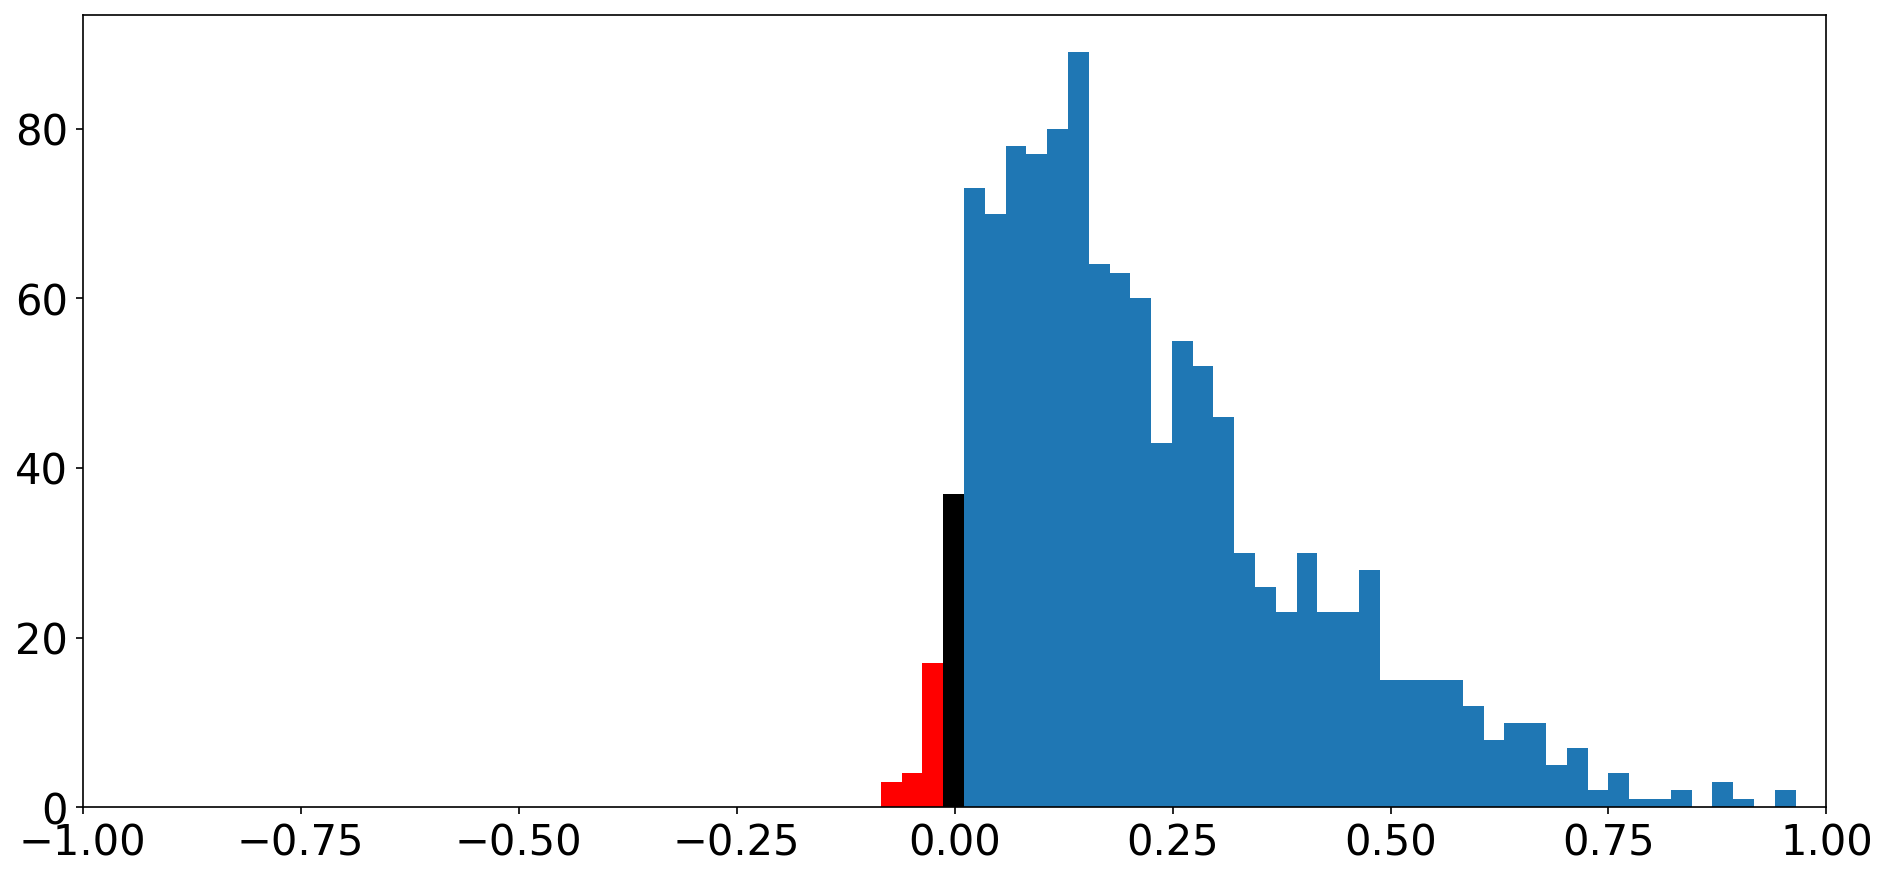

In [9]:
fig, ax = plt.subplots(1, 1, figsize=[15, 7], dpi=150)

# vals = thr_matrix.values[np.tril(np.ones(thr_matrix.shape).astype(bool), k=-1)]
# N, bins, patches = ax.hist(vals[np.nonzero(vals)], bins=50)
N, bins, patches = ax.hist(s_data.mean(-1), bins=50)
plt.xlim(-1, 1)
plt.xticks(size = 20)
plt.yticks(size = 20)

for i, p in enumerate(patches):
    if i < 3:
        p.set_facecolor('r')
    if i == 3:
        p.set_facecolor('k')

In [31]:
def thr_by_percentile(matrix, p=99.5):
    cop_mat = matrix.copy()
    mat_val = cop_mat.values
    hlf_val = np.tril(mat_val, k=-1) # half
    hlf_msk = np.nonzero(hlf_val)    # mask
    flt_val = hlf_val[hlf_msk]        # flatten
    
    flt_rnk = np.argsort(flt_val)   # ranked decending order (lower the high ranked)
    thr = flt_val[flt_rnk[np.round(flt_rnk.shape[0] * p/100).astype(int)]]
    cop_mat[cop_mat < thr] = 0
    return cop_mat

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 <a list of 10 Text major ticklabel objects>)

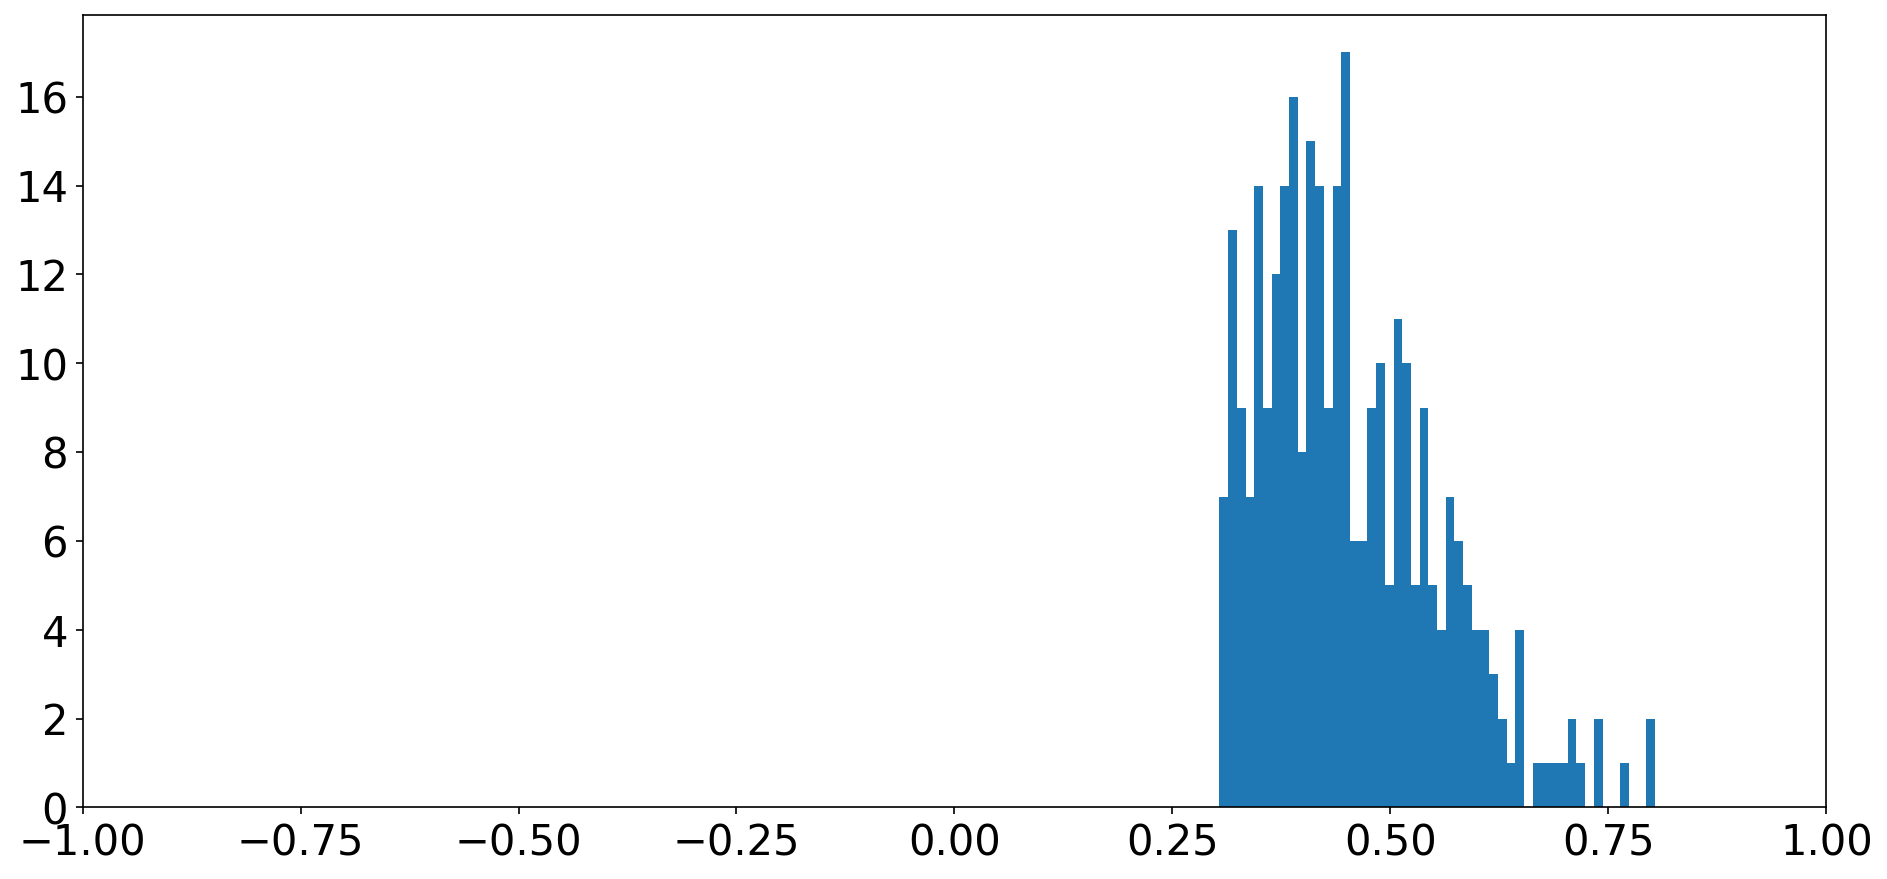

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[15, 7], dpi=150)

# vals = thr_matrix.values[np.tril(np.ones(thr_matrix.shape).astype(bool), k=-1)]
# N, bins, patches = ax.hist(vals[np.nonzero(vals)], bins=50)
sig_b_flat = sig_b.flatten()
N, bins, patches = ax.hist(sig_b_flat[np.nonzero(sig_b_flat)], bins=50)
plt.xlim(-1, 1)
plt.xticks(size = 20)
plt.yticks(size = 20)

In [38]:
import matplotlib
from matplotlib import patches
from matplotlib.colors import to_rgb

from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
from slfmri import io as slio
import copy

In [40]:
matplotlib.rcParams['lines.linewidth'] = 4
metric = 'euclidean'
method = 'ward'

# correlation / weighted
hier_groups = [6, 5, 8, 5, 6, 15, 5]
hier_comcon = [1, 1, 1, 1, 1,  1, 1]
hier_colors = [
    'lime',
    'greenyellow',
    'green',
    
    'mediumblue',
    'mediumpurple',
    'plum',
    'purple'
         ]

thr_matrix[~thr_matrix.notnull()] = 0
thr_matrix[thr_matrix == 1] = 0

# set thresholding distance for clustering
color_thr = 0.25
# Classify the cluster, the colors must have lenght larger then the length of the groups
ofname = oput_pm(f'Label-{metric}-{method}_{suffix}')

hier_colors += ['gray'] * (len(hier_groups) - len(hier_colors))

sns.set_style('white')
fig, ax = plt.subplots(1, 1, figsize=[80, 15], dpi=300)
Z = linkage(thr_matrix, method, metric=metric)
dend = dendrogram(Z, ax=ax, orientation='top', color_threshold=color_thr*max(Z[:,2]))
yt = plt.yticks(fontsize=40)
xt = plt.xticks(fontsize=40)

/opt/apps/pyenv/1.2.17/versions/3.7.6/envs/camri-tool/lib/python3.7/site-packages/ipykernel_launcher.py:31: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


/opt/apps/pyenv/1.2.17/versions/3.7.6/envs/camri-tool/lib/python3.7/site-packages/ipykernel_launcher.py:34: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


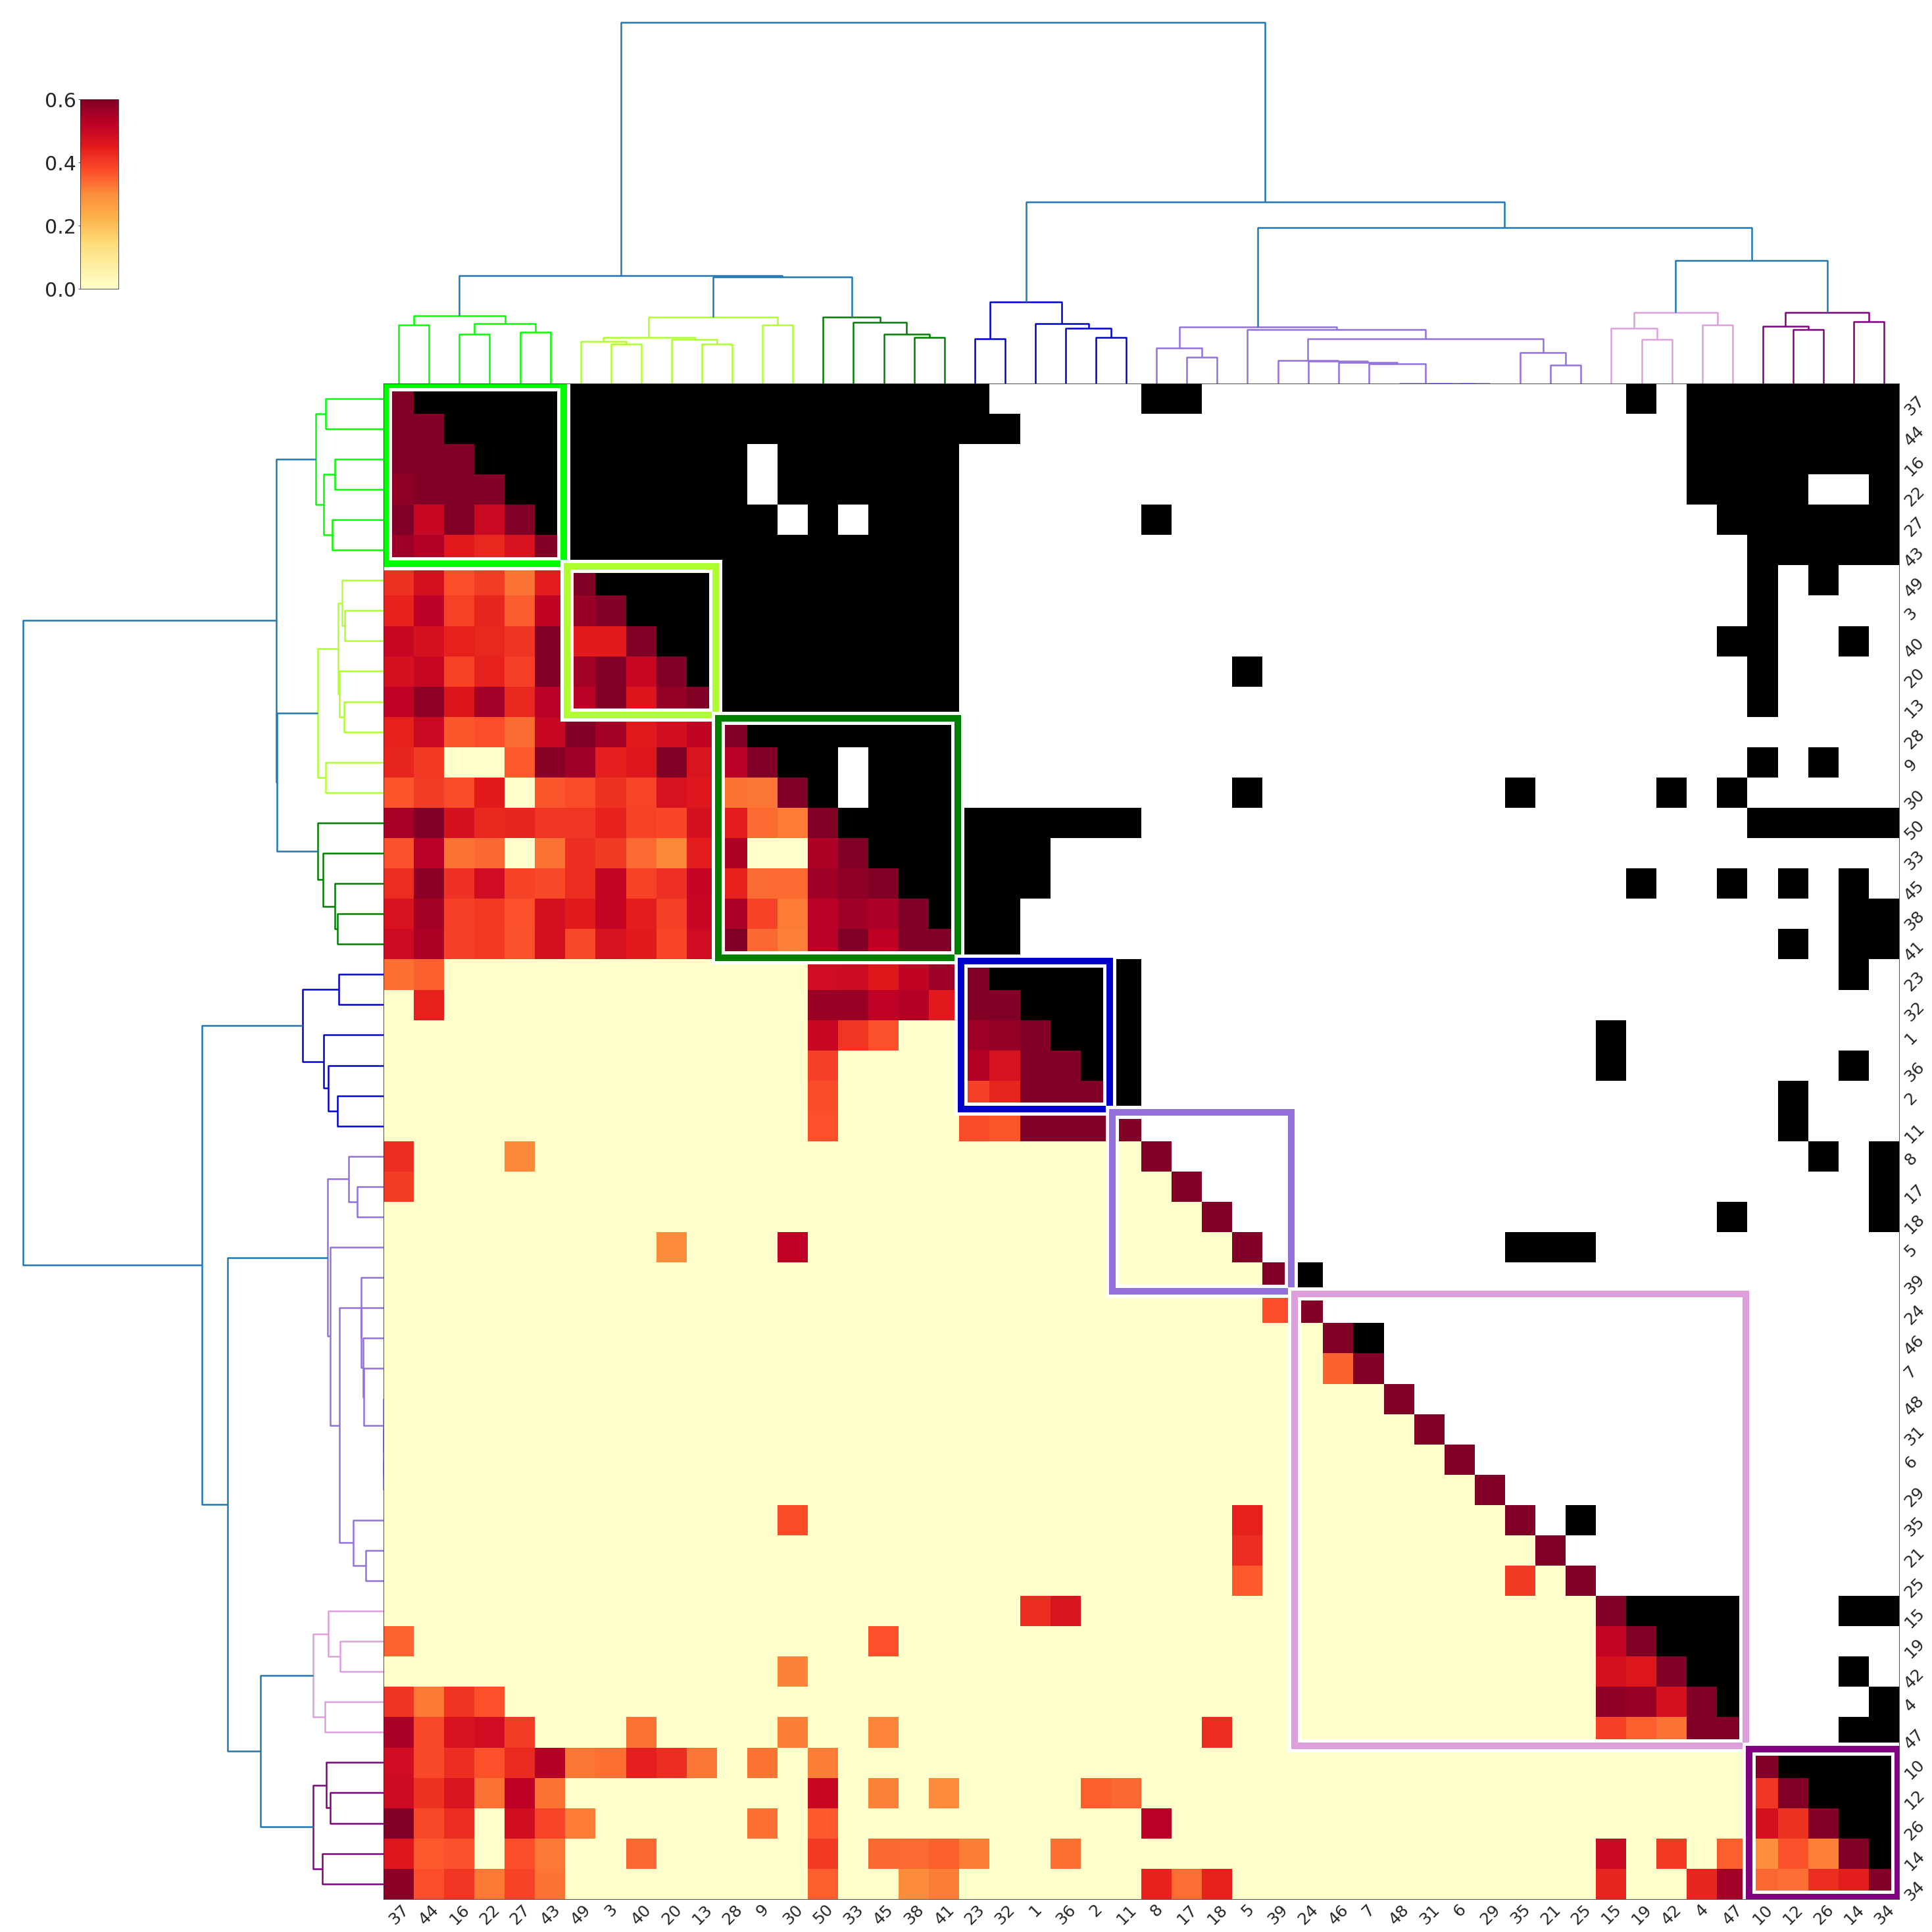

In [41]:
# Color mapping for dendrogram
set_link_color_palette(hier_colors)
matplotlib.rcParams['lines.linewidth'] = 2.5
sns.set_style('white')

# If true, update color scheme on label file
update_color_scheme = False

# prep figure and gridspec
figsize = np.array([40, 40])
fig = plt.figure(figsize=figsize, 
                 constrained_layout=False)
widths = [0.04, 0.02, 0.04, 0.02, 0.08, 0.8]
heights = [0.05, 0.1, 0.05, 0.8]
linewidth = 10

gs = fig.add_gridspec(nrows=4, ncols=6, 
                      left=0, right=1,
                      bottom=0, top=1,
                      wspace=0, hspace=0,
                      width_ratios=widths, 
                      height_ratios=heights)

# prep plot axes
ax_top_dend = fig.add_subplot(gs[:3, 5])
ax_lft_dend = fig.add_subplot(gs[3, :5])
ax_heatmap = fig.add_subplot(gs[3, 5])
cax = fig.add_subplot(gs[1, 1])

ax_top_dend.axis('off')
ax_lft_dend.axis('off')

# heirarchical clustering
Z = linkage(thr_matrix.values, method, metric=metric)

# dendrogram
dend_top = dendrogram(Z, ax=ax_top_dend, 
                      orientation='top', 
                      color_threshold=color_thr*max(Z[:,2]))
dend_lft = dendrogram(Z, ax=ax_lft_dend, 
                      orientation='left', 
                      color_threshold=color_thr*max(Z[:,2]))
ax_lft_dend.invert_yaxis()


df_1 = pd.DataFrame(thr_matrix.values + np.diag(np.ones(thr_matrix.shape[0]))).loc[dend_top['leaves'], 
                                                                                   dend_top['leaves']]
lower_mask = np.tril(np.ones(thr_matrix.shape))
df_2 = (df_1 != 0).astype(float)
df_2.values[np.nonzero(lower_mask)] = np.nan

hm = ax_heatmap.imshow(df_1, vmin=0, vmax=0.6, cmap='YlOrRd')
pm = ax_heatmap.imshow(df_2, vmin=0, vmax=1, cmap='gray_r')

fig.colorbar(hm, cax=cax, orientation='vertical')
cax.tick_params(axis='y', labelsize=30, pad=3)
cax.yaxis.tick_left()

ax_heatmap.yaxis.tick_right()
ax_heatmap.set_xticks(np.arange(0, thr_matrix.shape[0]))
ax_heatmap.set_yticks(np.arange(0, thr_matrix.shape[0]))
ax_heatmap.set_xticklabels([str(idx + 1) for idx in dend_top['leaves']], fontsize=25, rotation=45)
ax_heatmap.set_yticklabels([str(idx + 1) for idx in dend_top['leaves']], fontsize=25, rotation=45)
ax_heatmap.tick_params(axis='both', which='both', length=0)

colors = copy.copy(hier_colors)
groups = copy.copy(hier_groups)
comcon = copy.copy(hier_comcon)

# Draw squares for the cluster
for i, gid in enumerate(groups):
    if comcon[i]:
        cid = int(i)
        while cid >= len(colors):
            cid = cid-len(colors)
        color = colors[cid].split('_')[0]
        pch_size = gid-0.1
        pch_loc = sum(groups[:i]) - 0.45
        pch = patches.Rectangle([pch_loc, pch_loc], pch_size, pch_size, fill=False, 
                                linewidth=20, color='white')
        pcp = patches.Rectangle([pch_loc, pch_loc], pch_size, pch_size, fill=False, 
                                linewidth=10, color=color)
        ax_heatmap.add_patch(pch)
        ax_heatmap.add_patch(pcp)
    else:
        colors.insert(i, 'C0')
        c = 'C0'
        pch_size = gid-0.1
        pch_loc = sum(groups[:i]) - 0.45
        pch = patches.Rectangle([pch_loc, pch_loc], pch_size, pch_size, fill=False, 
                                linewidth=linewidth, color='white')
        pcp = patches.Rectangle([pch_loc, pch_loc], pch_size, pch_size, fill=False, 
                                linewidth=4, color=c)
        ax_heatmap.add_patch(pch)
        ax_heatmap.add_patch(pcp)

if update_color_scheme:
    atlas = slio.Atlas(oput_pm('Label-euclidean-ward_210630'))
    labels = np.array(dend_top['leaves']) + 1

    hier_dict = {c:[] for c in colors}
    counter = 0

    for i, n_comp in enumerate(groups):
        for _ in range(n_comp):
            c = colors[i]
            hier_dict[c].append(labels[counter])
            counter += 1

    for c, list_idx in hier_dict.items():
        for idx in list_idx:
            rgb = to_rgb(c.split('_')[0])
            atlas.cmap[idx] = rgb
    atlas.save_label(ofname)

In [30]:
atlas = slio.Atlas(oput_pm(f'Label-euclidean-ward_{suffix}'))
labels = np.array(dend_top['leaves']) + 1

hier_dict = {c:[] for c in colors}
counter = 0

for i, n_comp in enumerate(groups):
    for _ in range(n_comp):
        c = colors[i]
        hier_dict[c].append(labels[counter])
        counter += 1

for c, list_idx in hier_dict.items():
    for idx in list_idx:
        rgb = to_rgb(c.split('_')[0])
        atlas.cmap[idx] = rgb
atlas.save_label(ofname)

In [31]:
oput_pm._path

'./Step05_CommunityDetection'

In [42]:
import networkx as nx
import pickle
from community import best_partition, modularity, generate_dendrogram, partition_at_level

def matrix_to_graph(matrix, side='upper', random=False):
    matrix = matrix.copy()
    nodes = list(matrix.columns)
    if side == 'upper':
        m_arr = np.triu(matrix.values, k=-1)
    elif side == 'lower':
        m_arr = np.tril(matrix.values, k=-1)
    else:
        raise Exception
    g = nx.Graph()
    g.add_nodes_from(nodes)
    for i, j in np.transpose(np.nonzero(m_arr)):
        r = matrix.loc[nodes[i], nodes[j]]
        d = 1-r
        if random:
            node1, node2 = np.sort(np.random.choice(matrix.columns, 2))
            while g.get_edge_data(node1, node2) is not None:
                node1, node2 = np.sort(np.random.choice(matrix.columns, 2))
        else:
            node1, node2 = nodes[i], nodes[j]
        g.add_edge(node1, node2, weight=r, distance=d)
    return g

In [43]:
g = matrix_to_graph(abs(thr_matrix))
print(nx.info(g))

mod_path = oput_pm(f'modularity-iter5000_{code}.pkl')
if os.path.exists(mod_path):
    with open(mod_path, 'rb') as f:
        mod_dict = pickle.load(f)
else:
    mod_dict = dict(partition=[], modularity=[], dendrogram=[])
    for i in tqdm(range(5000)):
        part = best_partition(g, randomize=True)
        mod_dict['partition'].append(part)
        mod_dict['modularity'].append(modularity(part, g))
        mod_dict['dendrogram'].append(generate_dendrogram(g, randomize=True))
    mod_dict = pd.DataFrame(mod_dict)
    with open(mod_path, 'wb') as f:
        pickle.dump(mod_dict, f)
        
argmax = mod_dict.sort_values(by='modularity')[::-1].index[0]
best_set = mod_dict.loc[argmax, :]

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 312
Average degree:  12.4800


KeyboardInterrupt: 

In [44]:
modules = dict()
for idx, m in best_set.partition.items():
    if m not in modules.keys():
        modules[m] = []
    modules[m].append(idx)

In [45]:
hier_groups = [6, 5, 8, 5, 6, 15, 5]

ward_dict = dict()
group_id = 0
for i in [idx + 1 for idx in dend_top['leaves']]:
    if len(ward_dict.keys()) == 0:
        ward_dict[group_id] = []
    if len(ward_dict[group_id]) < hier_groups[group_id]:
        ward_dict[group_id].append(i)
    else:
        group_id += 1
        ward_dict[group_id] = [i]

In [46]:
modules

{0: [1, 2, 11, 23, 32, 36, 50],
 1: [3, 9, 13, 20, 22, 28, 30, 33, 38, 40, 41, 43, 44, 45, 49],
 2: [4, 8, 10, 12, 14, 15, 16, 17, 18, 19, 26, 27, 34, 37, 42, 47],
 3: [5, 21, 25, 35],
 4: [6],
 5: [7, 46],
 6: [24, 39],
 7: [29],
 8: [31],
 9: [48]}

In [47]:
ward_dict

{0: [37, 44, 16, 22, 27, 43],
 1: [49, 3, 40, 20, 13],
 2: [28, 9, 30, 50, 33, 45, 38, 41],
 3: [23, 32, 1, 36, 2],
 4: [11, 8, 17, 18, 5, 39],
 5: [24, 46, 7, 48, 31, 6, 29, 35, 21, 25, 15, 19, 42, 4, 47],
 6: [10, 12, 26, 14, 34]}

In [48]:
colm = [ # module 0
        [21, 46, 7, 31, # c5
         # cluster 4
        32, 23, 1, 36, 2, 11,
         # cluster 3
        50], 
         # module 1
        [33, 45, 38, 41,
         # cluster 2
        28, 13, 49, 3, 20, 30, 9, 22,
        39, # c5
         # cluster 1
        44, 40],
         # module 4
        [37, 27, 16,
        8, # c5
         # cluster 0
        10, 43, 12, 26, 14, 34],
         # module 2
         # cluster 6
        [4, 47, 15, 19, 42,
        18, 29], # c5
         # module 3
        [17, 5, 35, 25, 24, 48, 6], # c5
       ]

indice = [i for i in np.concatenate(colm)]

In [49]:
sig_mask = np.nonzero(sig_b[:, 0])
n_cells, n_subj, n_run = values.shape
n_sig_cells = sig_mask[0].shape[0]

sig_arr = np.zeros([n_sig_cells, n_subj, n_run])

for i in range(n_subj):
    for j in range(n_run):
        sig_arr[:, i, j] = values[:, i, j][sig_mask]

In [50]:
sig_arr.shape  # arr, subj, run

(306, 87, 3)

In [51]:
def cal_phi_ii(arr):
    # arr: numpy array with flatten correlation matrix x subj x run
    size_arr, num_subj, num_run = arr.shape
    pair_set = []
    for i in range(num_run):
        for j in range(num_run):
            if i < j:
                pair_set.append((i, j))   
    phi_set = np.zeros([size_arr, num_subj, len(pair_set)])
    for pid, pair in enumerate(pair_set):
        xid, yid = pair
        for sid in range(num_subj):
            sarr = arr[:, sid, [xid, yid]]
            sarr -= sarr.mean(0)
            sarr /= sarr.std(0)
            phi_set[:, sid, pid] = np.prod(sarr, 1)
    return phi_set.mean(-1)

def cal_phi_ij(arr):
    from tqdm.notebook import tqdm
    size_arr, num_subj, num_run = arr.shape
    pair_set = []
    phi_ij = np.zeros([size_arr, num_subj, (num_subj - 1)*num_run, num_run])
    for sid_i in tqdm(range(num_subj)):
        pop_count = 0
        for sid_j in range(num_subj):
            if sid_i != sid_j:
                for rid_j in range(num_run):
                    for rid_i in range(num_run):
                        arr_i = arr[:, sid_i, rid_i]
                        arr_j = arr[:, sid_j, rid_j]
                        sarr = np.c_[arr_i, arr_j]
                        sarr -= sarr.mean(0)
                        sarr /= sarr.std(0)
                        phi_ij[:, sid_i, pop_count, rid_i] = np.prod(sarr, 1)
                    pop_count += 1
    return phi_ij.mean(-1)

def differential_power(arr):
    _, num_subj, num_run = arr.shape
    # compute edge-wise product vector (phi_ii) within subject
    phi_ii = cal_phi_ii(arr)
    # compute edge-wise product vector (phi_ij) between subjects
    phi_ij = cal_phi_ij(arr)
    # match matrix dim for matrix operation
    phi_ii = np.concatenate([phi_ii[..., np.newaxis] for i in range(phi_ij.shape[-1])], -1) 
    
    # compute an empirical probability
    pi_e = (phi_ij > phi_ii).astype(int)
    pi_e = pi_e.sum(-1)/(num_run*(num_subj-1))
    
    # to avoid divide by zero, divide by DoF * 2
    minval = 1/((num_run*(num_subj-1))*2) 
    pi_e = pi_e.clip(min=minval)
    
    # compute differntial power (DP)
    dp_e = (-1 * np.log(pi_e)).sum(1)
    return dp_e

def group_consistency(arr):
    phi_ii = cal_phi_ii(arr)
    # compute the mean of phi_i across all subject
    return phi_ii.mean(-1)

def get_ranked_at(data1d, p_val=0.05):
    num_data = data1d.shape[0]
    thr = int(num_data * (1-p_val))
    ranks = np.argsort(data1d)
    return (ranks > thr).astype(int)

def convert_to_matrix(data, fisher=False):
    n = Symbol('n')
    eq = n*(n-1) - data.shape[0]*2
    num_col = [s for s in solve(eq) if s > 0][0]
    
    # Check positive connectivity matrix
    matrix_mask = np.tril(np.ones([num_col] * 2), k=-1)
    output_matrix = matrix_mask * 0
    if fisher:
        mat = np.tanh(data)
    else:
        mat = data.copy()
    output_matrix[np.nonzero(matrix_mask)] = mat
    output_matrix = fill_upperhalf(output_matrix)
    
    # remove zero values for plotting
    thr_matrix = output_matrix.copy()
    thr_matrix[thr_matrix == 0] = np.nan
    thr_matrix.columns += 1
    thr_matrix.index += 1
    return thr_matrix

In [52]:
## With one sample t-test mask
# dp = differential_power(values[sig_mask])
# phi = group_consistency(values[sig_mask])
# dp_half = np.zeros(values.shape[0])
# dp_half[sig_mask] = dp

# phi_half = np.zeros(values.shape[0])
# phi_half[sig_mask] = phi


# All data
dp = differential_power(values)
phi = group_consistency(values)

In [64]:
indice = np.concatenate([m for m in module_dict.values()])

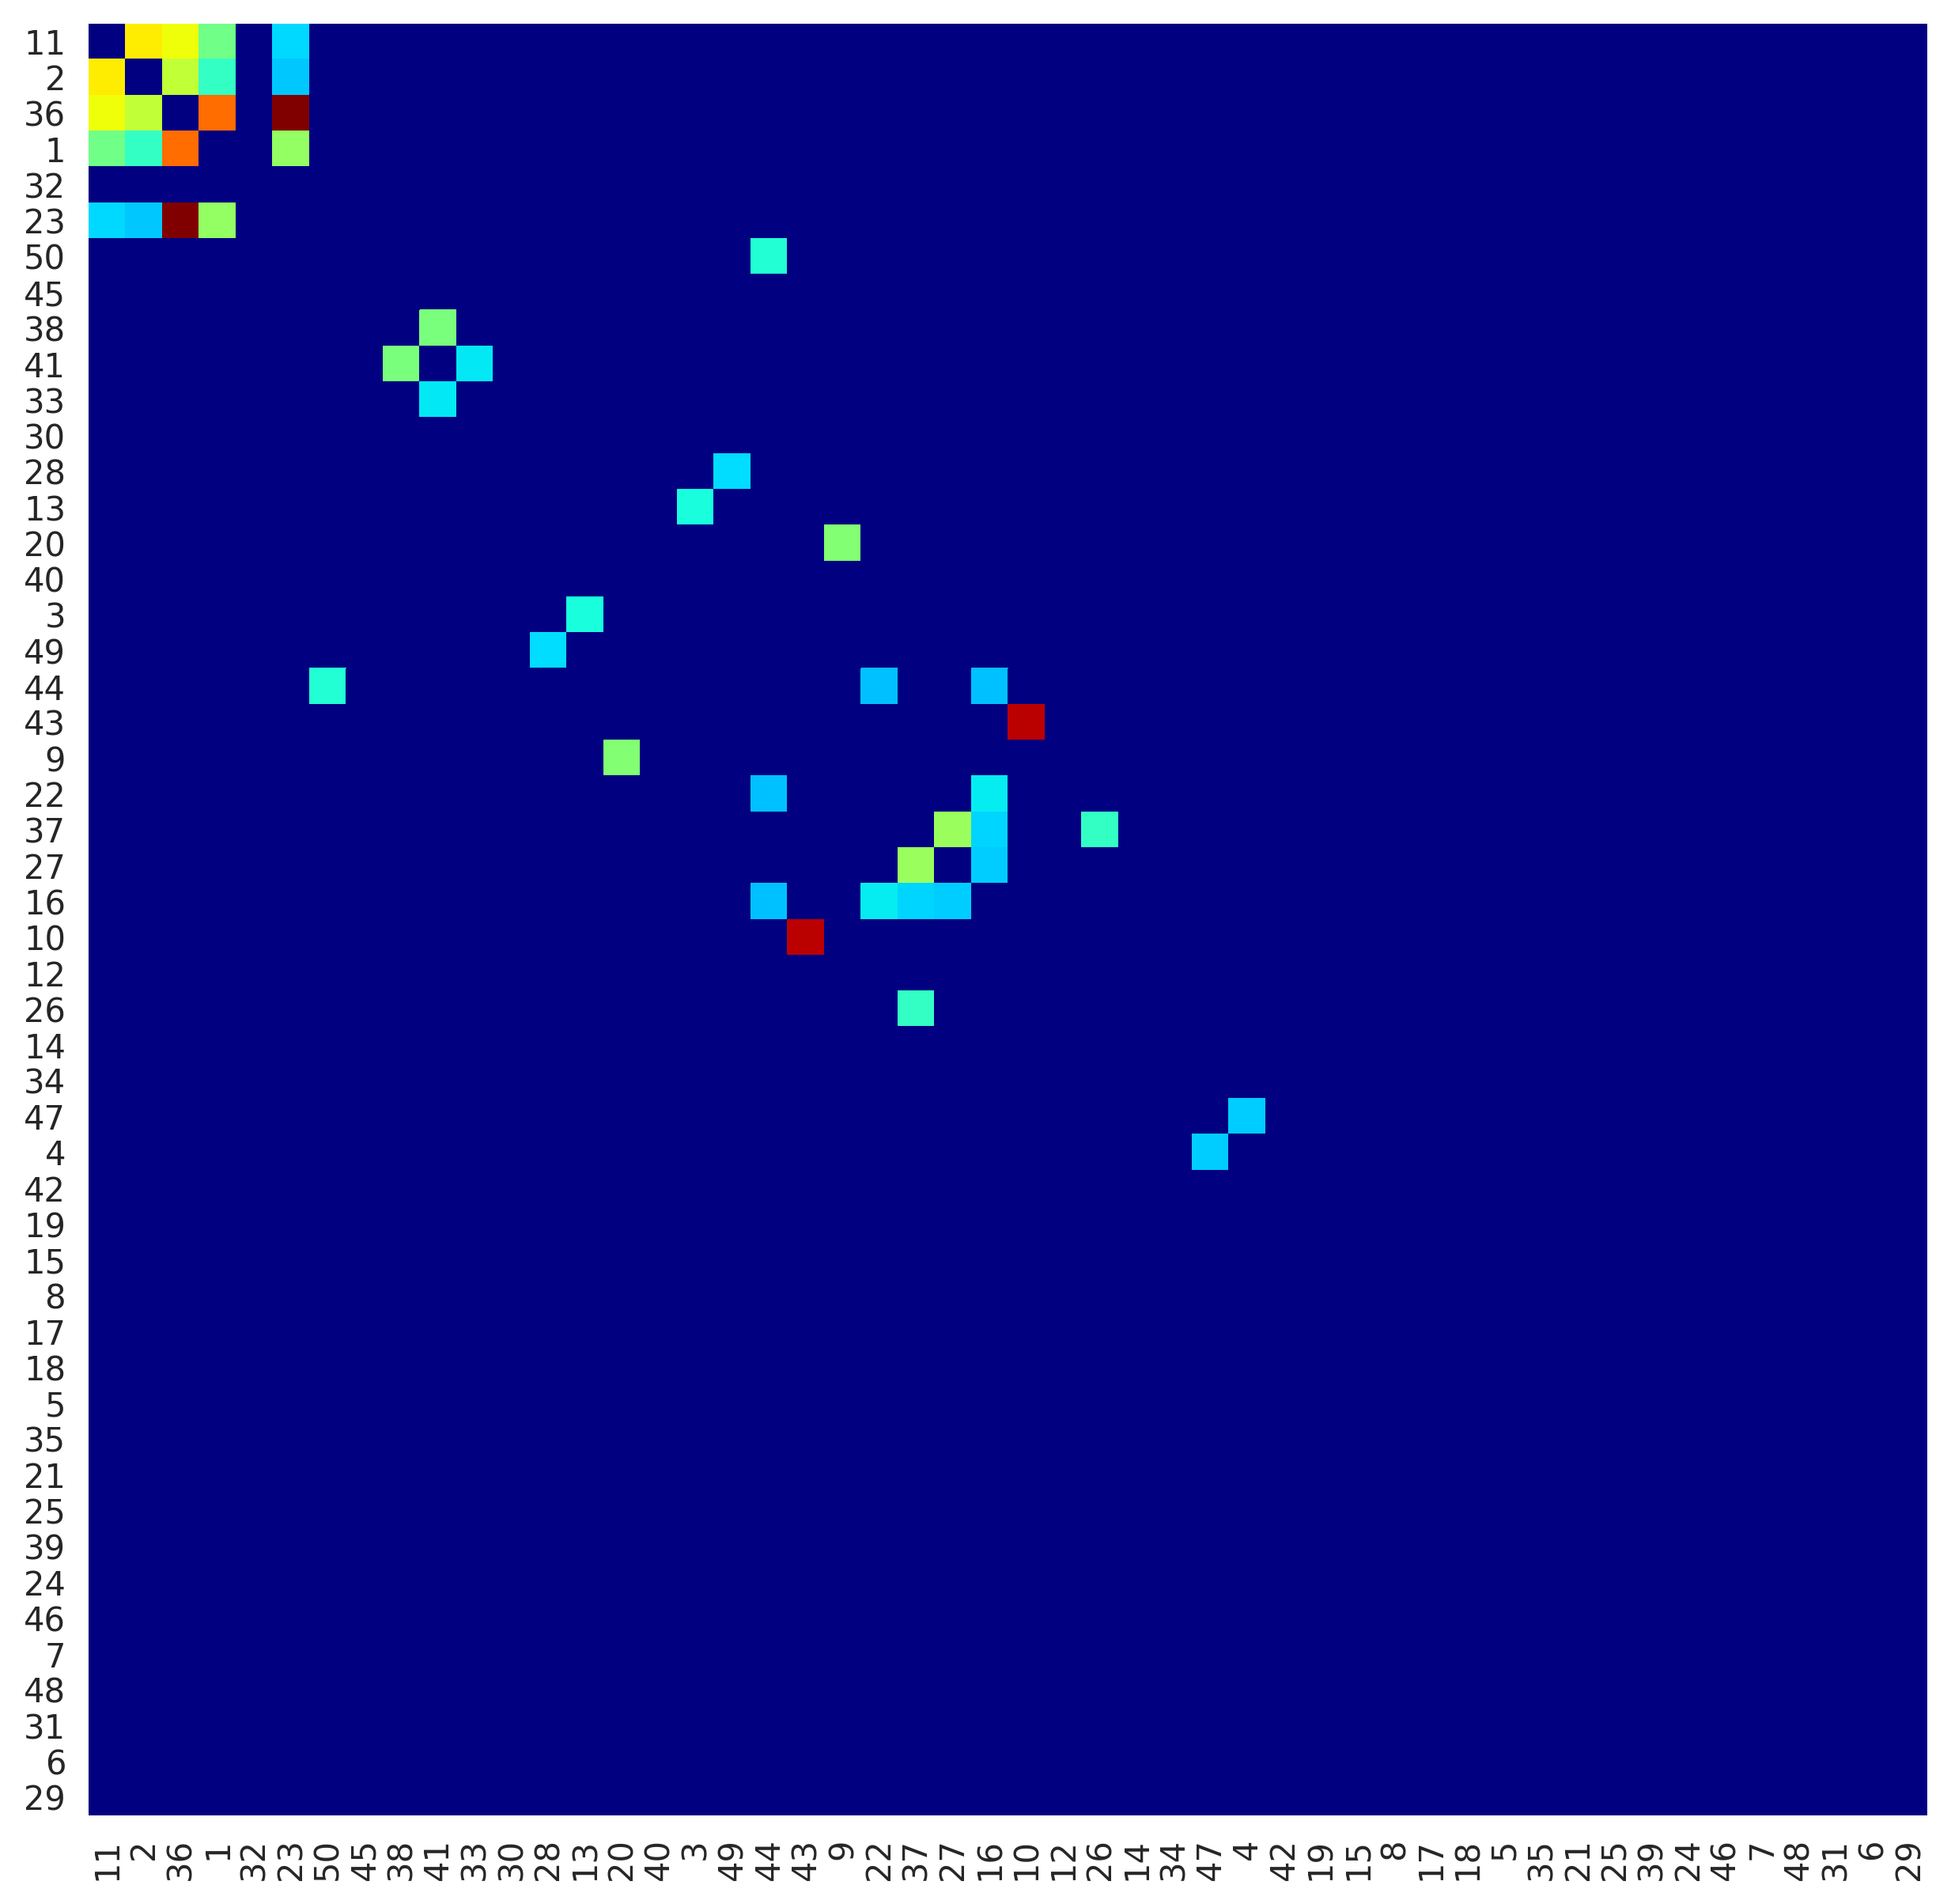

In [94]:
pval = 0.01

# dp_mat = convert_to_matrix(get_ranked_at(dp_half, pval))
# phi_mat = convert_to_matrix(get_ranked_at(phi_half, pval))
dp_mat = convert_to_matrix(dp).loc[indice, indice]
phi_mat = convert_to_matrix(phi).loc[indice, indice]

fig, ax = plt.subplots(1, 1, figsize=[10, 10], dpi=300)
sns.heatmap(thr_by_percentile(dp_mat, 98), ax=ax, cbar=False, cmap='jet')
sns.heatmap(thr_by_percentile(phi_mat, 98), ax=ax, cbar=False, cmap='jet')

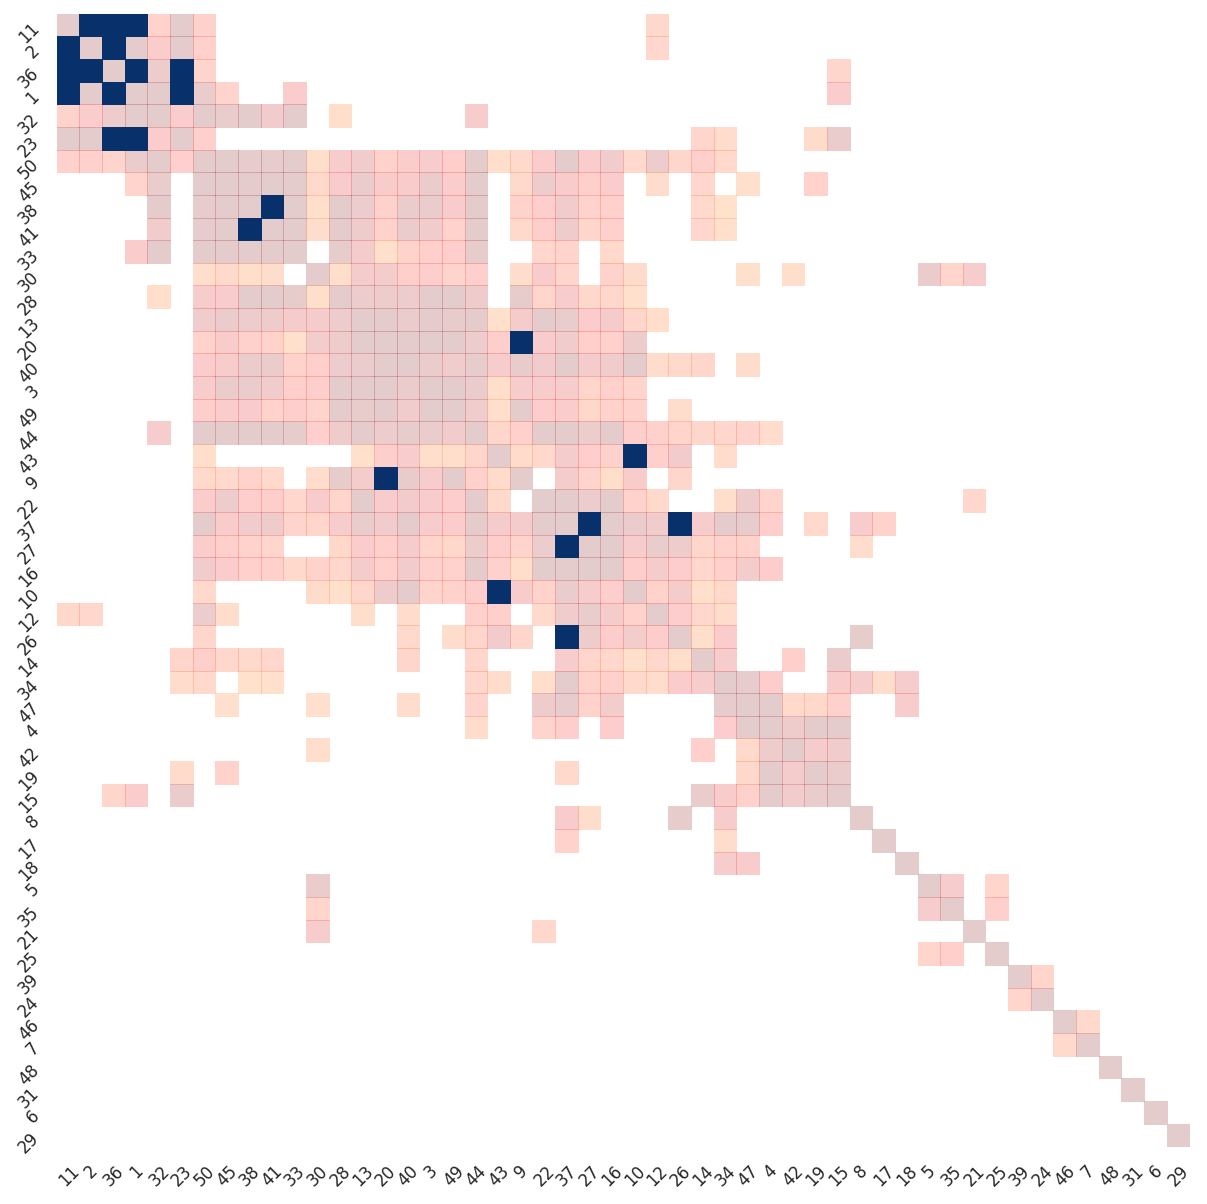

In [116]:
# visualization
label_fontsize = 8

n = Symbol('n')
eq = n*(n-1) - s_data.shape[0]*2
num_col = [s for s in solve(eq) if s > 0][0]

# Check positive connectivity matrix
matrix_mask = np.tril(np.ones([num_col] * 2), k=-1)
output_matrix = matrix_mask * 0
output_matrix[np.nonzero(matrix_mask)] = np.tanh(sig_b[..., 0])
output_matrix = fill_upperhalf(output_matrix)

# remove zero values for plotting
thr_matrix = output_matrix.copy()
thr_matrix[thr_matrix == 0] = np.nan
thr_matrix.columns += 1
thr_matrix.index += 1

fig, ax = plt.subplots(1, 1, figsize=(15,10), dpi=150)
sns.heatmap(thr_matrix.loc[indice, indice], ax=ax, vmin=-0.5, vmax=0.5, cmap='jet', alpha=0.2, cbar=False)
thr_phi_mat = thr_by_percentile(phi_mat, 99)
thr_phi_mat[thr_phi_mat == 0] = np.nan
sns.heatmap(thr_phi_mat, ax=ax, cbar=False, cmap='Blues', vmin=0, vmax=2)

ax.set_aspect(1)   # result shows 'all positive'

_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=label_fontsize, rotation=45)
_ = ax.set_yticklabels(ax.get_yticklabels(), fontsize=label_fontsize, rotation=45)

In [112]:
module_dict = dict(M1=[11, 2, 36, 1, 32, 23, 50],
                   M2=[45, 38, 41, 33, 30, 28, 13, 20, 40, 3, 49, 44, 43, 9, 22],
                   M3=[37, 27, 16, 10, 12, 26, 14, 34, 47, 4, 42,19, 15, 8, 17, 18],
                   M4=[5, 35, 21, 25],
                   M5=[39, 24, 46, 7, 48, 31, 6, 29])

In [104]:
net_gc_mat = np.zeros([5, 5])

for i, (mid1, lbls1) in enumerate(module_dict.items()):
    for j, (mid2, lbls2) in enumerate(module_dict.items()):
        if i >= j:
            if mid1 == mid2:
                n_surv_edges = np.nonzero(np.tril(thr_phi_mat.notna().loc[lbls1, lbls2].values, k=-1))[0].shape[0]
            else:
                n_surv_edges = np.nonzero(thr_phi_mat.notna().loc[lbls1, lbls2].values)[0].shape[0]
            net_gc_mat[i, j] = n_surv_edges

net_gc_mat /= net_gc_mat.sum()
net_gc_mat = pd.DataFrame(net_gc_mat, index=module_dict.keys(), columns=module_dict.keys())
net_gc_mat

,M1,M2,M3,M4,M5
M1,0.583333,0.000000,0.000000,0.0,0.0
M2,0.000000,0.166667,0.000000,0.0,0.0
M3,0.000000,0.083333,0.166667,0.0,0.0
M4,0.000000,0.000000,0.000000,0.0,0.0
M5,0.000000,0.000000,0.000000,0.0,0.0


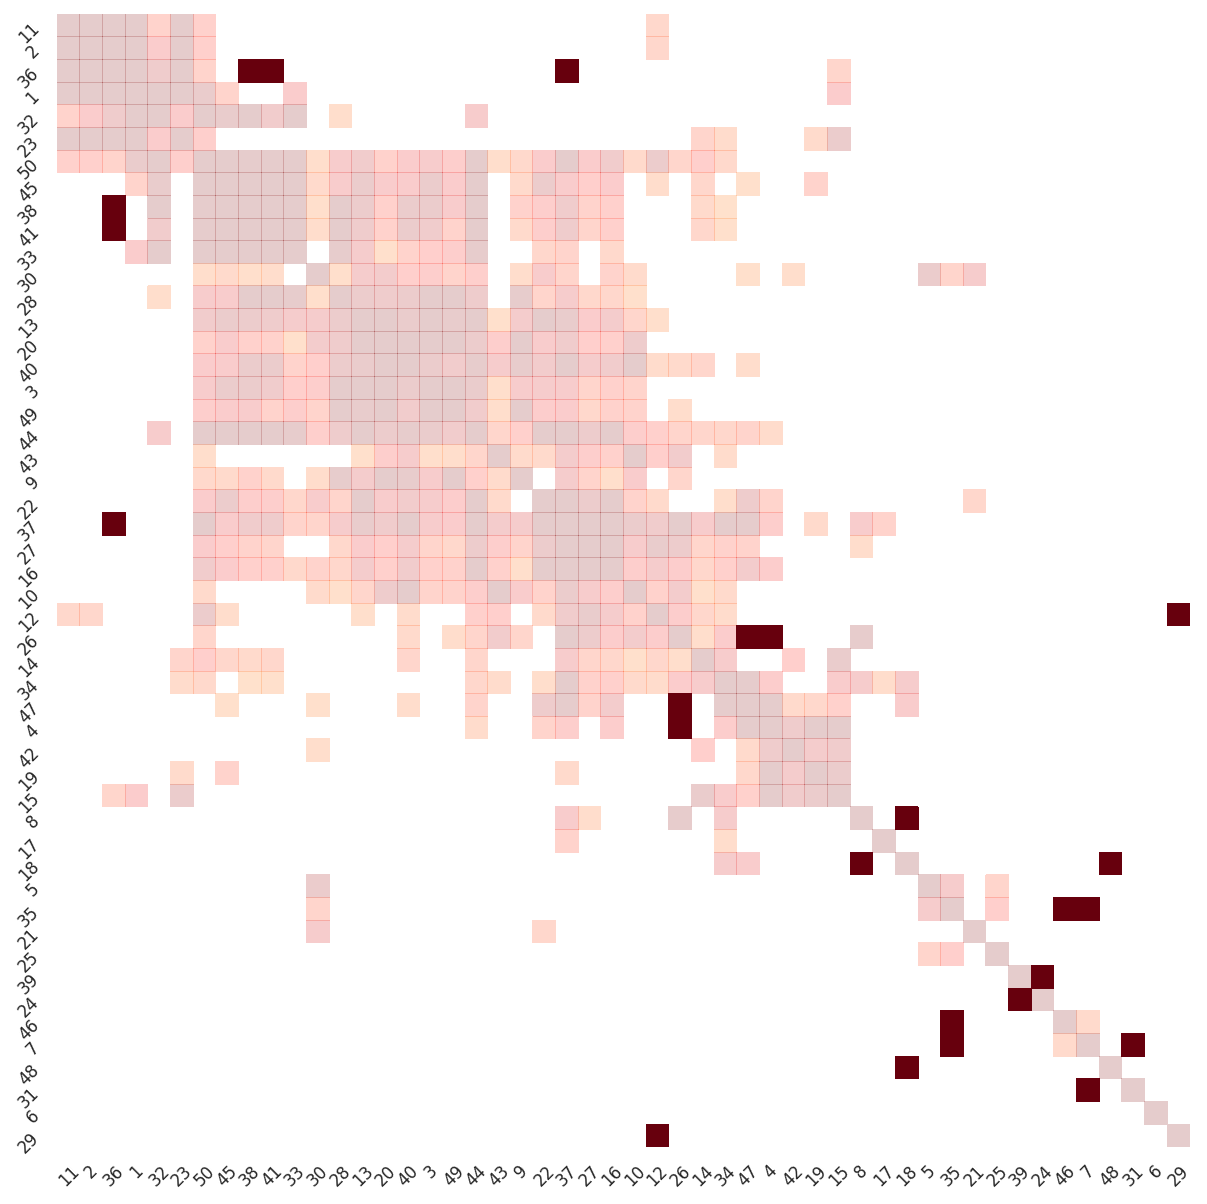

In [115]:
# visualization
label_fontsize = 8

n = Symbol('n')
eq = n*(n-1) - s_data.shape[0]*2
num_col = [s for s in solve(eq) if s > 0][0]

# Check positive connectivity matrix
matrix_mask = np.tril(np.ones([num_col] * 2), k=-1)
output_matrix = matrix_mask * 0
output_matrix[np.nonzero(matrix_mask)] = np.tanh(sig_b[..., 0])
output_matrix = fill_upperhalf(output_matrix)

# remove zero values for plotting
thr_matrix = output_matrix.copy()
thr_matrix[thr_matrix == 0] = np.nan
thr_matrix.columns += 1
thr_matrix.index += 1

fig, ax = plt.subplots(1, 1, figsize=(15,10), dpi=150)
sns.heatmap(thr_matrix.loc[indice, indice], ax=ax, vmin=-0.5, vmax=0.5, cmap='jet', alpha=0.2, cbar=False)
thr_dp_mat = thr_by_percentile(dp_mat, 99)
thr_dp_mat[thr_dp_mat == 0] = np.nan
sns.heatmap(thr_dp_mat, ax=ax, cbar=False, cmap='Reds', vmin=-2, vmax=2)

ax.set_aspect(1)   # result shows 'all positive'

_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=label_fontsize, rotation=45)
_ = ax.set_yticklabels(ax.get_yticklabels(), fontsize=label_fontsize, rotation=45)

In [109]:
net_dp_mat = np.zeros([5, 5])

for i, (mid1, lbls1) in enumerate(module_dict.items()):
    for j, (mid2, lbls2) in enumerate(module_dict.items()):
        if i >= j:
            if mid1 == mid2:
                n_surv_edges = np.nonzero(np.tril(thr_dp_mat.notna().loc[lbls1, lbls2].values, k=-1))[0].shape[0]
            else:
                n_surv_edges = np.nonzero(thr_dp_mat.notna().loc[lbls1, lbls2].values)[0].shape[0]
            net_dp_mat[i, j] = n_surv_edges
            
net_dp_mat /= net_dp_mat.sum()
net_dp_mat = pd.DataFrame(net_dp_mat, index=module_dict.keys(), columns=module_dict.keys())
net_dp_mat

,M1,M2,M3,M4,M5
M1,0.000000,0.0,0.000000,0.000000,0.000000
M2,0.166667,0.0,0.000000,0.000000,0.000000
M3,0.083333,0.0,0.250000,0.000000,0.000000
M4,0.000000,0.0,0.000000,0.000000,0.000000
M5,0.000000,0.0,0.166667,0.166667,0.166667


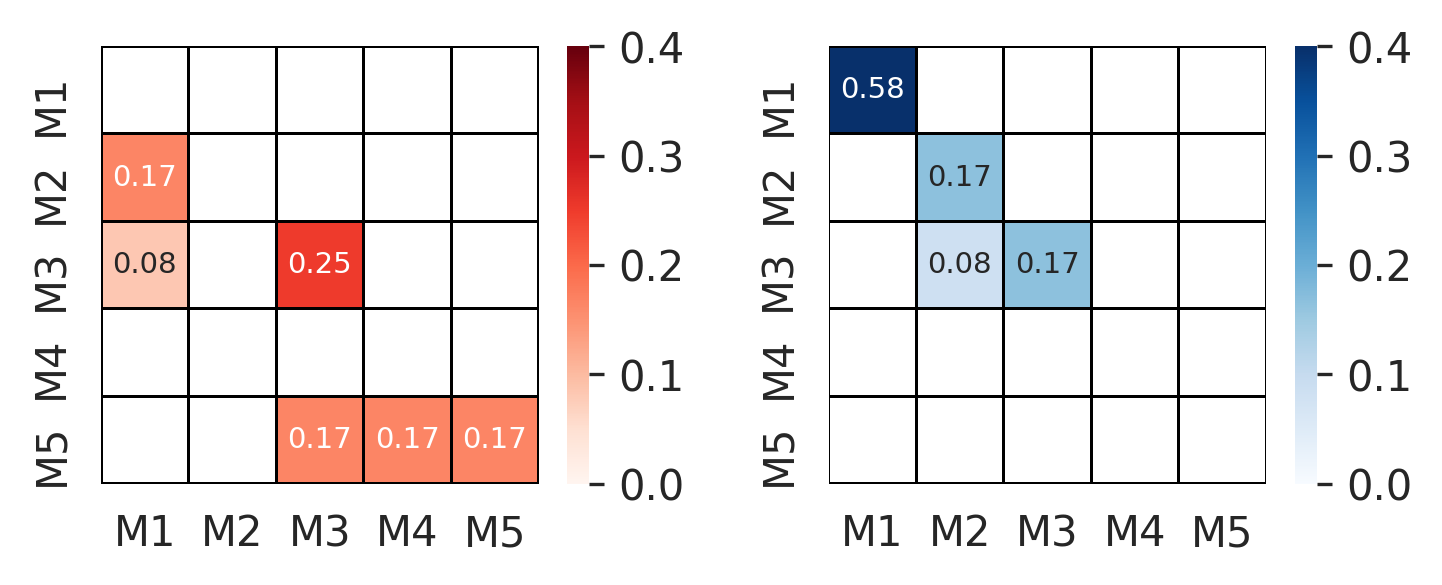

In [113]:
fig, axes = plt.subplots(1, 2, figsize=[5, 2], dpi=300)

net_gc_mat[net_gc_mat == 0] = np.nan
sns.heatmap(net_gc_mat, linewidths=.5, cmap='Blues', linecolor='black', ax=axes[1], vmin=0, vmax=0.4, annot=True,
            annot_kws={"fontsize":7}, fmt='.2f')
axes[1].set_aspect(1)

net_dp_mat[net_dp_mat == 0] = np.nan
sns.heatmap(net_dp_mat, linewidths=.5, cmap='Reds', linecolor='black', ax=axes[0], vmin=0, vmax=0.4, annot=True,
            annot_kws={"fontsize":7}, fmt='.2f')
axes[0].set_aspect(1)

plt.tight_layout()